# Dataset Definition

New model release:

https://www.databricks.com/blog/introducing-dbrx-new-state-art-open-llm

In [6]:
import pandas as pd

# QA
questions = [
    "How many tokens was DBRX pre-trained on?",
    "Is DBRX a MOE model and how many parameters does it have?",
    "How many GPUs was DBRX trained on and what was the connectivity between GPUs?"
]

answers = [
    "DBRX was pre-trained on 12 trillion tokens of text and code data.",
    "Yes, DBRX is a fine-grained mixture-of-experts (MoE) architecture with 132B total parameters.",
    "DBRX was trained on 3072 NVIDIA H100s connected by 3.2Tbps Infiniband"
]

# Dataset
qa_pairs = [{"question": q, "answer": a} for q, a in zip(questions, answers)]

# DF
df = pd.DataFrame(qa_pairs)

# Write to csv
csv_path = "/Users/rlm/Desktop/DBRX_eval.csv"
df.to_csv(csv_path, index=False)

# LangSmith Dataset Creation

With LangSmith SDK: 

https://docs.smith.langchain.com/evaluation/quickstart#1-create-a-dataset

With UI:

https://docs.smith.langchain.com/evaluation/faq/datasets-webapp

In [ ]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true' # enables tracing 
os.environ['LANGCHAIN_API_KEY'] = <your-api-key>

In [9]:
from langsmith import Client

client = Client()
dataset_name = "DBRX Dataset"

# Store
dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="QA pairs about DBRX model.",
)
client.create_examples(
    inputs=[{"question": q} for q in questions],
    outputs=[{"answer": a} for a in answers],
    dataset_id=dataset.id,
)

In [ ]:
new_questions = [
    "What is the context window of DBRX Instruct?", 
]

new_answers = [
    "DBRX Instruct was trained with up to a 32K token context window.",
]

# See updated version in the UI
client.create_examples(
    inputs=[{"question": q} for q in new_questions],
    outputs=[{"answer": a} for a in new_answers],
    dataset_id=dataset.id,
)

# Adding Traces to dataset

With LangSmith UI

In [23]:
# Create a project

import os
os.environ['LANGCHAIN_PROJECT'] = 'DBRX'

In [31]:
# Load website

import requests
from bs4 import BeautifulSoup
url = 'https://www.databricks.com/blog/introducing-dbrx-new-state-art-open-llm'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
text = [p.text for p in soup.find_all('p')]
full_text = '\n'.join(text)

In [88]:
# OpenAI API

import openai
from langsmith.wrappers import wrap_openai
openai_client = wrap_openai(openai.Client())

def predict(inputs: dict) -> dict:
    """
    Generates answers to user questions based on a provided website text using OpenAI API.

    Parameters:
    inputs (dict): A dictionary with a single key 'question', representing the user's question as a string.

    Returns:
    dict: A dictionary with a single key 'output', containing the generated answer as a string.
    """

    # System prompt 
    system_msg = f"Answer user questions in 2-3 sentences about this context: \n\n\n {full_text}"
    
    # Pass in website text
    messages = [{"role": "system", "content": system_msg},
                {"role": "user", "content": inputs["question"]}]

    # Call OpenAI
    response = openai_client.chat.completions.create(messages=messages, model="gpt-3.5-turbo")

    # Response in output dict, as expected by dataset 
    return {"answer": response.dict()['choices'][0]['message']['content']} 
    
predict({"question":"What are the main differences in training efficiency between MPT-7B vs DBRX?"})

{'answer': "DBRX's training efficiency significantly improved compared to MPT-7B. A model from the DBRX family, DBRX MoE-A, reached a similar Gauntlet score to MPT-7B with 3.7x fewer FLOPs. This efficiency boost was achieved through various improvements, including an MoE architecture, better optimization strategies, enhanced pretraining data quality, and other architectural changes."}

# LLM-as-Judge with built-in evaluator

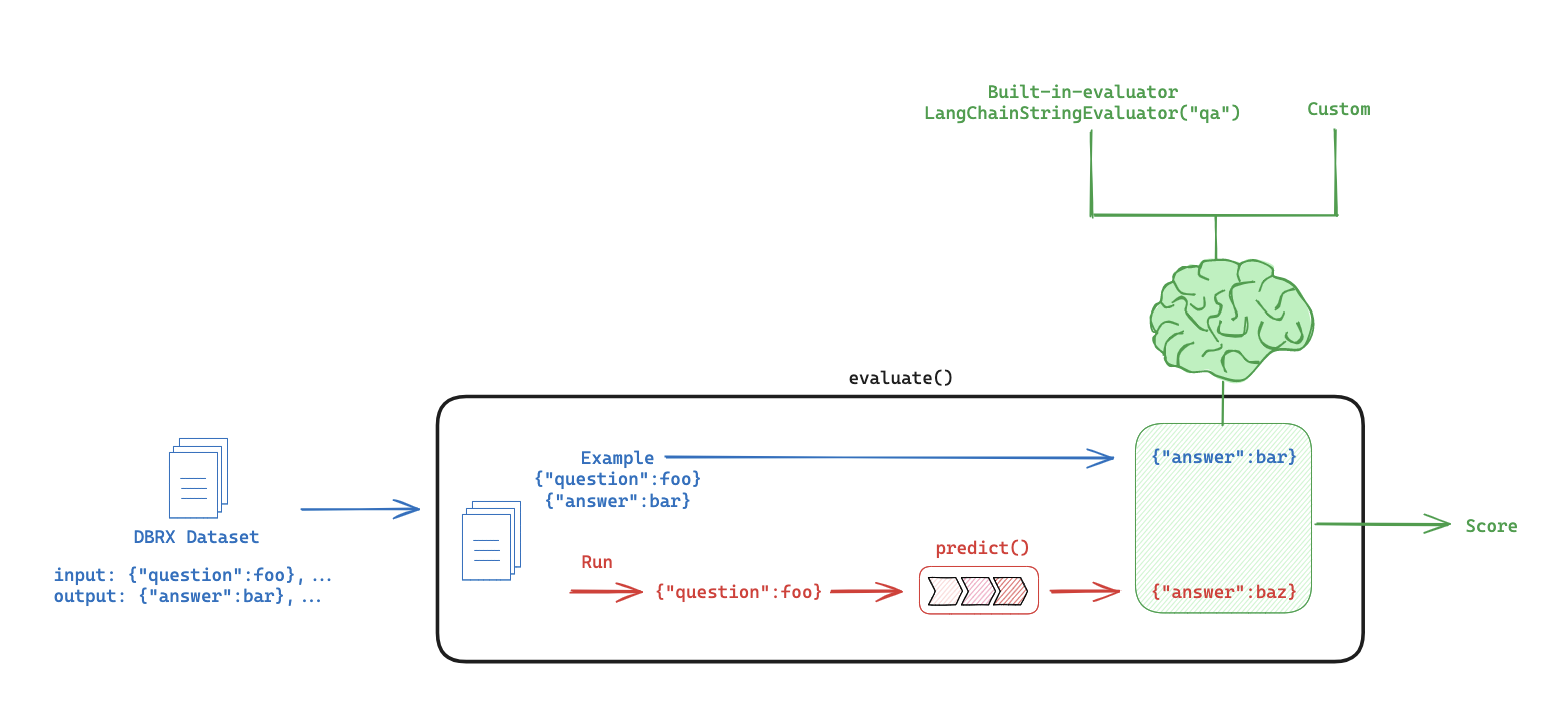

Evaluate:

https://docs.smith.langchain.com/evaluation/quickstart#3-evaluate

Using built-in evaluators: 

* Automatically infers the key

https://docs.smith.langchain.com/evaluation/faq/evaluator-implementations#correctness-qa-evaluation

In [93]:
from langsmith.evaluation import evaluate, LangChainStringEvaluator

# Evaluators
qa_evalulator = [LangChainStringEvaluator("qa")]

experiment_results = evaluate(
    predict,
    data=dataset_name,
    evaluators=qa_evalulator,
    experiment_prefix="test-dbrx-qa",
    # Any experiment metadata can be specified here
    metadata={
      "version": "1.0.0",
      "variant": "stuff website context",
    },
)

/var/folders/l9/bpjxdmfx7lvd1fbdjn38y5dh0000gn/T/ipykernel_82405/3772700711.py:6: UserWarning: Function evaluate is in beta.
  experiment_results = evaluate(


View the evaluation results for experiment: 'test-dbrx-qa:d4aefa4' at:
https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/datasets/accb4d34-55ee-431e-8fb1-5b0a0a3bd033/compare?selectedSessions=d4a244d7-c0df-442a-aac3-5f3f84ada480




0it [00:00, ?it/s]

# Custom evaluator


In [92]:
def is_answered(run: Run, example: Example) -> dict: 

    # Get outputs
    student_answer = run.outputs.get("answer")
    
   # Check if the student_answer is an empty string
    if not student_answer:
        return {"key": "is_answered" , "score": 0} 
    else:
        return {"key": "is_answered" , "score": 1} 

# Evaluators
qa_evalulator = [is_answered]

# Run
experiment_results = evaluate(
    predict,
    data=dataset_name,
    evaluators=qa_evalulator,
    experiment_prefix="test-dbrx-qa-custom-eval-is-answered",
    # Any experiment metadata can be specified here
    metadata={
      "version": "1.0.0",
      "variant": "stuff website context",
    },
)

/var/folders/l9/bpjxdmfx7lvd1fbdjn38y5dh0000gn/T/ipykernel_82405/3303443300.py:16: UserWarning: Function evaluate is in beta.
  experiment_results = evaluate(


View the evaluation results for experiment: 'test-dbrx-qa-custom-eval-is-answered:17d0152' at:
https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/datasets/accb4d34-55ee-431e-8fb1-5b0a0a3bd033/compare?selectedSessions=2d771ff0-6059-4681-9b82-74318a5fdd17




0it [00:00, ?it/s]

# LLM-as-Judge with custom evaluator

https://docs.smith.langchain.com/evaluation/quickstart#3-evaluate

In [91]:
from langsmith.schemas import Run, Example
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

class CheckExplicit(BaseModel):
    """Check if output has explicit langugage"""

    grade: int = Field(description="Grade 1 if the output has explicit langugage, else 0.")

def grade_answer(run: Run, example: Example) -> dict: 

    # Get outputs
    student_answer = run.outputs.get("answer")
    
    # LLM with function call 
    llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
    grader_llm = llm.with_structured_output(CheckExplicit)
    
    # Prompt 
    system = """Check if the generation from the LLM has explicit langugage"""
    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "STUDENT ANSWER: {student_answer}"),
        ]
    )

    # Invoke
    grader = grade_prompt | grader_llm
    score = grader.invoke({"student_answer":student_answer,})

    # Score is required?
    return {"key": "grade" , "score": score.grade} 

# Evaluators
qa_evalulator = [grade_answer]

# Run
experiment_results = evaluate(
    predict,
    data=dataset_name,
    evaluators=qa_evalulator,
    experiment_prefix="test-dbrx-qa-custom-eval-explicit",
    # Any experiment metadata can be specified here
    metadata={
      "version": "1.0.0",
      "variant": "stuff website context",
    },
)

/var/folders/l9/bpjxdmfx7lvd1fbdjn38y5dh0000gn/T/ipykernel_82405/2694562460.py:40: UserWarning: Function evaluate is in beta.
  experiment_results = evaluate(


View the evaluation results for experiment: 'test-dbrx-qa-custom-eval-explicit:82e8e38' at:
https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/datasets/accb4d34-55ee-431e-8fb1-5b0a0a3bd033/compare?selectedSessions=a232c150-9f94-474a-95d0-79323d3dfc0e




0it [00:00, ?it/s]

Let's assume we want this:

https://github.com/openai/evals/blob/main/evals/registry/modelgraded/closedqa.yaml

In [90]:
from langsmith.schemas import Run, Example
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

class Grade(BaseModel):
    """Grade LLM anser relative to reference."""

    grade: int = Field(description="Grade 1 if the student answer matches the reference, else 0.")

def grade_answer(run: Run, example: Example) -> dict:

    # Get 
    student = run.outputs.get("answer")
    question = example.outputs.get("question")
    answer = example.outputs.get("answer")
    
    # LLM with function call 
    llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
    grader_llm = llm.with_structured_output(Grade)
    
    # Prompt 
    system = """You are assessing a submitted STUDENT ANSWER to a question relative to the TRUE ANSWER based on the provided criteria:\n
    conciseness:  Is the student answer concise and to the point? \n
    correct: Is the student answer correct relative to the reference answer? \n
    Does the student answer the criterion? \n
    First, write out in a step by step manner your reasoning about the criterion to be sure that your conclusion is correct. \n
    Return 1 if the student answer meets the criteria and 0 if it does not."""
    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "QUESTION: {question} \n STUDENT ANSWER: {student} \n TRUE ANSWER: {answer}"),
        ]
    )

    # Invoke
    grader = grade_prompt | grader_llm
    score = grader.invoke({"student":student,"answer":answer,"question":question})

    # Store
    return {"key": "grade" , "score": score.grade} # score is required?

# Evaluators
qa_evalulator = [grade_answer]

# Run
experiment_results = evaluate(
    predict,
    data=dataset_name,
    evaluators=qa_evalulator,
    experiment_prefix="test-dbrx-qa-custom-eval",
    # Any experiment metadata can be specified here
    metadata={
      "version": "1.0.0",
      "variant": "stuff website context",
    },
)

/var/folders/l9/bpjxdmfx7lvd1fbdjn38y5dh0000gn/T/ipykernel_82405/2956306874.py:46: UserWarning: Function evaluate is in beta.
  experiment_results = evaluate(


View the evaluation results for experiment: 'test-dbrx-qa-custom-eval:91acf71' at:
https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/datasets/accb4d34-55ee-431e-8fb1-5b0a0a3bd033/compare?selectedSessions=e82b3329-0319-4f15-aec6-281b01f7ae33




0it [00:00, ?it/s]